In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
from torch_DNN_class_v2 import ANNModel

def load_and_process_data(file_path, optimal_n_components=0.99):

    all_columns = ["Fy_steel", "E_steel", "Gama_steel", "Nu_steel", "tT_Top_tower", "tT_Bot_tower", 
                   "thickness_monopile", "M_nacelle", "M_hub", "M_blade", "GammaSoil", "Phi_soil", 
                   "G_soil", "VAve_Wind", "Hs_Wave", "Damping", 
                   "TowerTopDisp_IM1_a", "TowerTopDisp_IM1_b", "TowerTopDisp_IM1_Beta", 
                   "TowerTopAcc_IM2_a", "TowerTopDisp_IM2_b", "TowerTopDisp_IM2_Beta", 
                   "TowerTopDisp_IM3_a", "TowerTopDisp_IM3_b", "TowerTopDisp_IM3_Beta"]

    features = all_columns[:16]
    labels = all_columns[16:]

    sheets = pd.read_excel(file_path, sheet_name=None)

    dfs = []

    for sheet_name, df in sheets.items():

        assert set(all_columns).issubset(df.columns), f"Missing columns in sheet {sheet_name}"

        df = df[all_columns]
        label_rename = {label: f"{label}_{sheet_name}" for label in labels}
        df = df.rename(columns=label_rename)

        dfs.append(df)

    combined_df = pd.concat(dfs, axis=1)

    final_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

    expected_columns = len(features) + len(labels) * len(sheets)
    assert final_df.shape[1] == expected_columns, f"Expected {expected_columns} columns, got {final_df.shape[1]}"
    X = final_df[features].values
    y = final_df.iloc[:, 16:].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=optimal_n_components)
    X_pca = pca.fit_transform(X_scaled)

    scaler_pca = MinMaxScaler()
    X_pca_scaled = scaler_pca.fit_transform(X_pca)

    return X_pca_scaled, y, scaler, scaler_pca, pca

def load_model_from_file(model_path):
    filename = os.path.basename(model_path)
    trial_number = int(filename.split('_')[1])
    r2_score = float(filename.split('_')[-1].replace('.pth', ''))
    
    model = torch.load(model_path)
    model.eval()
    
    return trial_number, model, r2_score

def load_all_models(all_models_dir):
    models = []
    for filename in os.listdir(all_models_dir):
        if filename.endswith('.pth'):
            model_path = os.path.join(all_models_dir, filename)
            models.append(load_model_from_file(model_path))
    return sorted(models, key=lambda x: x[2], reverse=True)

def predict(trained_model, X, device):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        return trained_model(X_tensor).cpu().numpy()

def inject_white_noise(data, noise_level=0.01, seed=None):
    if seed is not None:
        np.random.seed(seed)
    return data + np.random.normal(0, noise_level, data.shape)

def linear_calibration_fit(input_data_list, output_data):
    all_coefficients = []
    all_intercepts = []
    for input_data in input_data_list:
        model = LinearRegression().fit(input_data, output_data)
        all_coefficients.append(model.coef_)
        all_intercepts.append(model.intercept_)
    return all_coefficients, all_intercepts

def linear_transform(input_data, a, b):
    return np.matmul(input_data, a.T) + b

def BGA_weights(y_pred, y_test):
    sigma2_all = np.array([np.sum((y_test - pred) ** 2, axis=0) / len(y_test) for pred in y_pred])
    return (1 / sigma2_all) / np.sum(1 / sigma2_all, axis=0)

def GRA_weights(y_pred, y_test):
    n, m = y_test.shape
    k_num = len(y_pred)
    y_pred_tensor = np.array(y_pred).transpose(1, 0, 2)
    weights = np.zeros((k_num, m))
    for i in range(m):
        D = y_pred_tensor[:, :, i]
        Y = y_test[:, i]
        DtD = np.matmul(D.T, D)
        DtD_inv = np.linalg.inv(DtD)
        DtY = np.matmul(D.T, Y)
        weights[:, i] = np.matmul(DtD_inv, DtY)
    return weights

def WA_multi_output(y_pred, weights):
    return np.sum([pred * weights[i] for i, pred in enumerate(y_pred)], axis=0)

if __name__ == "__main__":
    file_path = 'D:/project/fusion_DL_wind_turbine_fragility_analysis/data/5MW_Offshore_Fragility.xlsx'
    X_pca_scaled, y, scaler, scaler_pca, pca = load_and_process_data(file_path, optimal_n_components=0.99)
    X_train, X_test, y_train, y_test = train_test_split(X_pca_scaled, y, test_size=0.25, random_state=99, shuffle=True)

    all_models_dir = "top_models"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_models = load_all_models(all_models_dir)

    predict_all = [predict(model.to(device), X_test, device) for _, model, _ in all_models]
    noisy_X_test = inject_white_noise(X_test, noise_level=0.01, seed=42)
    pred_noisy_all = [predict(model.to(device), noisy_X_test, device) for _, model, _ in all_models]
    
    
    predict_cal = [predict(model.to(device), X_train, device) for _, model, _ in all_models]

    a, b = linear_calibration_fit(predict_cal, y_train)
    y_pred_clbr_all = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(predict_all)]
    y_pred_clbr_noisy_all = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(pred_noisy_all)]
    
    pred_train=[predict(model.to(device), X_train, device) for _, model, _ in all_models]
    y_pred_train_all=[linear_transform(pred, a[i], b[i]) for i, pred in enumerate(pred_train)]

    w_GRA = GRA_weights(y_pred_clbr_all, y_test)
    w_BGA = BGA_weights(y_pred_clbr_all, y_test)

    y_pred_GRA = WA_multi_output(y_pred_clbr_all, w_GRA)
    y_pred_BGA = WA_multi_output(y_pred_clbr_all, w_BGA)
    y_pred_GRA_noisy = WA_multi_output(y_pred_clbr_noisy_all, w_GRA)
    y_pred_BGA_noisy = WA_multi_output(y_pred_clbr_noisy_all, w_BGA)

    print(f"GRA Ensemble R² Score: {r2_score(y_test, y_pred_GRA)}")
    print(f"BGA Ensemble R² Score: {r2_score(y_test, y_pred_BGA)}")
    print(f"GRA Ensemble R² Score (Noisy): {r2_score(y_test, y_pred_GRA_noisy)}")
    print(f"BGA Ensemble R² Score (Noisy): {r2_score(y_test, y_pred_BGA_noisy)}")
    
    sorted_r2_scores=[]

    for i, (trial_number, _, _) in enumerate(all_models):
        
        r2_calib=r2_score(y_test, y_pred_clbr_all[i])
        sorted_r2_scores.append(r2_calib)
        print(f"Calibrated Model {trial_number} R² Score: {r2_calib}")
        print(f"Calibrated Model {trial_number} R² Score (Noisy): {r2_score(y_test, y_pred_clbr_noisy_all[i])}")

    # np.savez('y_pred_clbr_all.npz', *y_pred_clbr_all)
    # np.savez('y_pred_clbr_noisy_all.npz', *y_pred_clbr_noisy_all)
    # np.savez('y_test_org.npz', y_test)
    
    


GRA Ensemble R² Score: 0.882144133234117
BGA Ensemble R² Score: 0.6194650874001923
GRA Ensemble R² Score (Noisy): 0.8220503416571969
BGA Ensemble R² Score (Noisy): 0.6232976596393514
Calibrated Model 37 R² Score: 0.5864615720677476
Calibrated Model 37 R² Score (Noisy): 0.5872636753097704
Calibrated Model 52 R² Score: 0.5741623859471816
Calibrated Model 52 R² Score (Noisy): 0.5744849073170656
Calibrated Model 51 R² Score: 0.56594384694499
Calibrated Model 51 R² Score (Noisy): 0.5672540446449368
Calibrated Model 64 R² Score: 0.5571992626172444
Calibrated Model 64 R² Score (Noisy): 0.5593922679993845
Calibrated Model 31 R² Score: 0.5500344490151021
Calibrated Model 31 R² Score (Noisy): 0.5453102799693235
Calibrated Model 55 R² Score: 0.528385924312509
Calibrated Model 55 R² Score (Noisy): 0.5344426577848683
Calibrated Model 41 R² Score: 0.5239583694043684
Calibrated Model 41 R² Score (Noisy): 0.5215359728313075
Calibrated Model 34 R² Score: 0.5235761468607678
Calibrated Model 34 R² Score 

In [3]:
# Save calibration parameters (a and b)
def save_calibration_params(a, b, filename='calibration_params.npz'):
    np.savez(filename, a=a, b=b)
    print(f"Calibration parameters saved to {filename}")

save_calibration_params(a, b, filename='calibration_params.npz')

Calibration parameters saved to calibration_params.npz


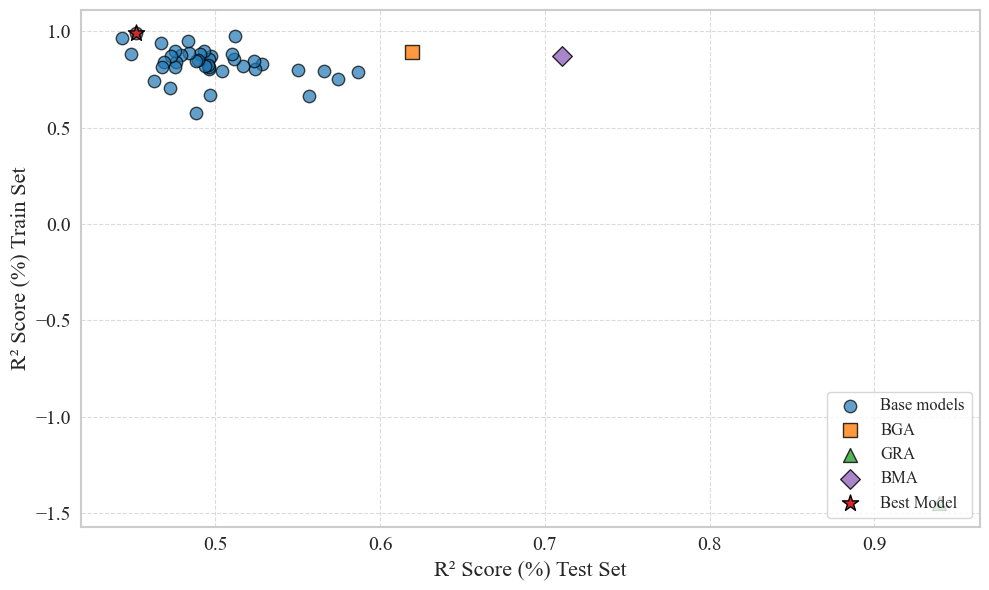

Scatter plot data saved successfully.


In [3]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os

# Load BMA weights
bma_weights = np.load('bma_weights_40_models_mixture.npy') 

def BMA_multi_output(y_pred, bma_weights, device='cuda' if torch.cuda.is_available() else 'cpu'):
    bma_weights_tensor = torch.tensor(bma_weights, dtype=torch.float32).to(device)  
    y_pred_tensor = torch.tensor(y_pred[0], dtype=torch.float32).to(device)
    y_avg = torch.zeros_like(y_pred_tensor)
    for i in range(len(y_pred)):
        y_pred_tensor = torch.tensor(y_pred[i], dtype=torch.float32).to(device)
        weights_broadcasted = bma_weights_tensor[:, i].unsqueeze(0).expand(y_pred_tensor.shape[0], -1)
        y_avg += y_pred_tensor * weights_broadcasted
    return y_avg.cpu().numpy()

# Calculate predictions for train set
GRA_pred_train = WA_multi_output(y_pred_train_all, w_GRA)
BGA_pred_train = WA_multi_output(y_pred_train_all, w_BGA)
BMA_pred_train = BMA_multi_output(y_pred_train_all, bma_weights)

# Calculate R² scores for train set
R2_train_GRA = r2_score(y_train, GRA_pred_train)
R2_train_BGA = r2_score(y_train, BGA_pred_train)
R2_train_BMA = r2_score(y_train, BMA_pred_train)
R2_train_all = [r2_score(y_train, pred) for pred in y_pred_train_all]

# Calculate R² scores for test set (for comparison)
R2_test_GRA = r2_score(y_test, WA_multi_output(y_pred_clbr_all, w_GRA))
R2_test_BGA = r2_score(y_test, WA_multi_output(y_pred_clbr_all, w_BGA))
R2_test_BMA = r2_score(y_test, BMA_multi_output(y_pred_clbr_all, bma_weights))
R2_test_all = [r2_score(y_test, pred) for pred in y_pred_clbr_all]

# Find the best model based on train set performance
best_model_index = np.argmax(R2_train_all)
best_model_R2_train = R2_train_all[best_model_index]
best_model_R2_test = R2_test_all[best_model_index]

# Visualization
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(R2_test_all, R2_train_all, color='#1f77b4', edgecolor='black', s=80, alpha=0.7, marker='o', label='Base models')
ax.scatter(R2_test_BGA, R2_train_BGA, color='#ff7f0e', edgecolor='black', s=100, alpha=0.8, marker='s', label='BGA')
ax.scatter(R2_test_GRA, R2_train_GRA, color='#2ca02c', edgecolor='black', s=100, alpha=0.8, marker='^', label='GRA')
ax.scatter(R2_test_BMA, R2_train_BMA, color='#9467bd', edgecolor='black', s=100, alpha=0.8, marker='D', label='BMA')

# Show best model
ax.scatter(R2_test_all[best_model_index], R2_train_all[best_model_index], color='#d62728', edgecolor='black', s=150, alpha=1, marker='*', label='Best Model')

ax.set_xlabel('R² Score (%) Test Set', fontsize=16)
ax.set_ylabel('R² Score (%) Train Set', fontsize=16)

ax.legend(fontsize=12, frameon=True, loc='lower right')
ax.grid(True, linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=14)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('model_performance_comparison_train_vs_test.tiff', format='tiff', dpi=600, bbox_inches='tight')
plt.show()

os.makedirs('visual_data', exist_ok=True)

np.savez('visual_data/scatter_plot_data_train_vs_test.npz',
         R2_train_all=R2_train_all,
         R2_test_all=R2_test_all,
         R2_train_BGA=R2_train_BGA,
         R2_test_BGA=R2_test_BGA,
         R2_train_GRA=R2_train_GRA,
         R2_test_GRA=R2_test_GRA,
         R2_train_BMA=R2_train_BMA,
         R2_test_BMA=R2_test_BMA,
         best_model_index=best_model_index)

print("Scatter plot data saved successfully.")

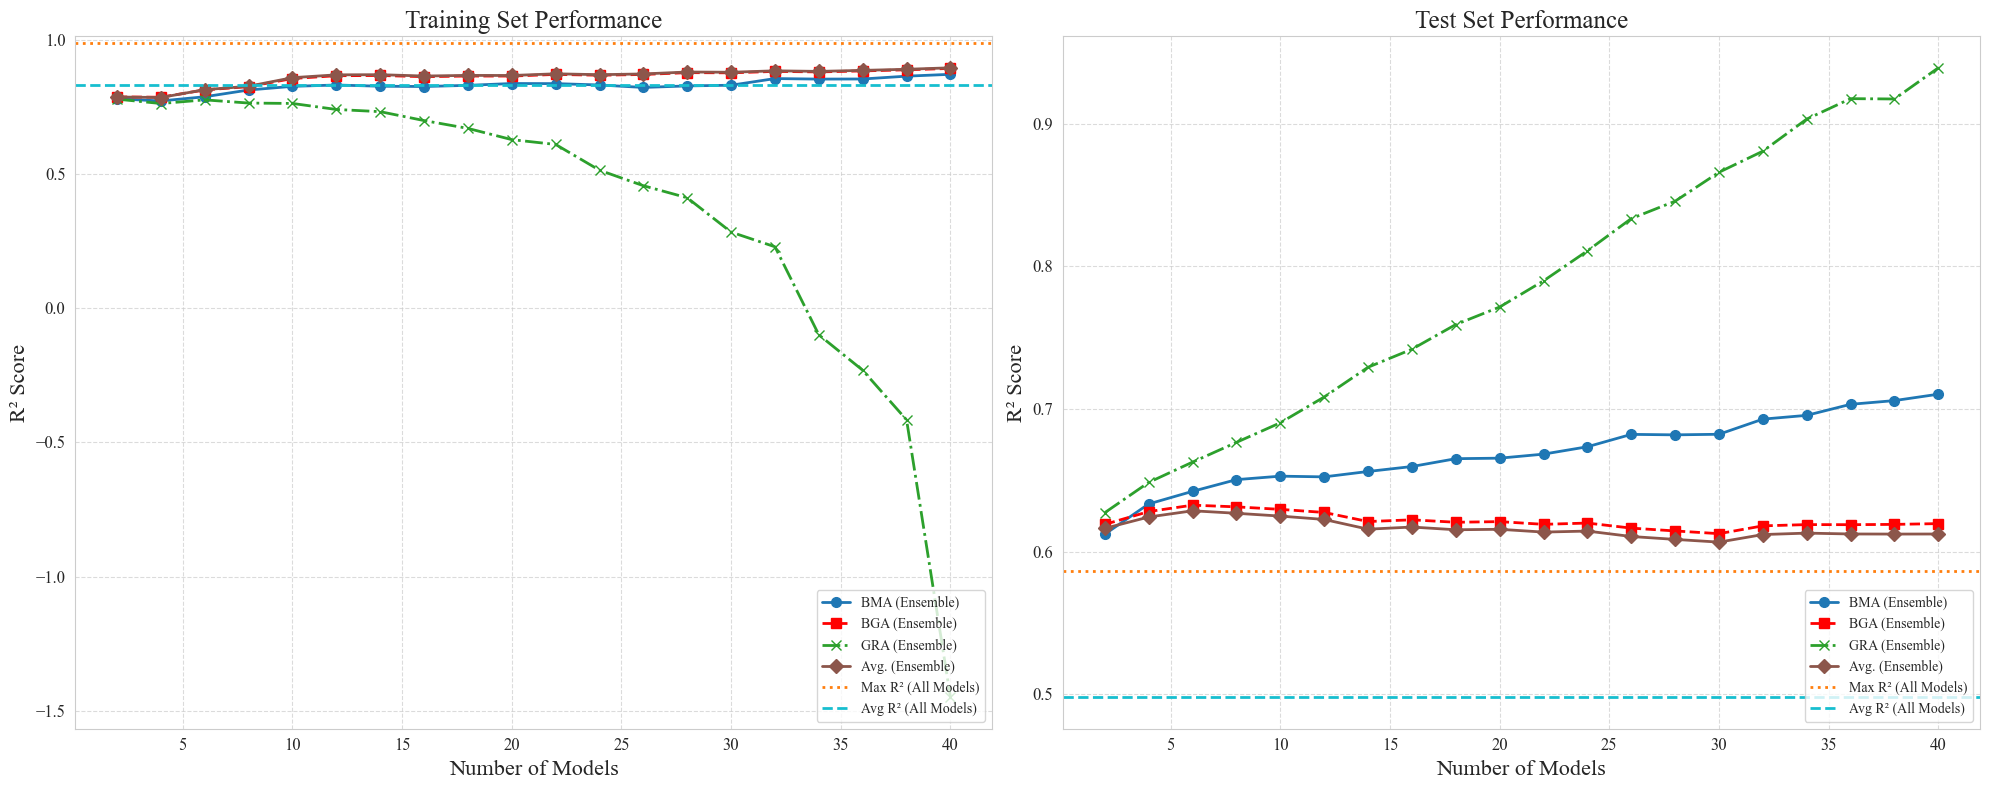

Ensemble performance data saved successfully.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import os

max_models = len(all_models)
model_range = range(2, max_models+1, 2)

def evaluate_ensemble_performance(pred_weights, y_weights, predictions, y_true, num_models, a, b,bma_w):
    selected_predictions = predictions[:num_models]
    
    y_pred_clbr_all = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(selected_predictions)]
    
    selected_predictions_w = pred_weights[:num_models]

    y_pred_clbr_all_w = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(selected_predictions_w)]
    
    
    # Calculate weights
    w_GRA = GRA_weights(y_pred_clbr_all_w, y_weights)
    w_BGA = BGA_weights(y_pred_clbr_all_w, y_weights)
    
    
    bma_weights =bma_w/np.tile(bma_w.sum(axis=1), (num_models, 1)).T
    
    # print((bma_w.sum(axis=0)))
    # Ensemble predictions
    # print(np.shape(y_pred_clbr_all))
    BMA_pred = BMA_multi_output(y_pred_clbr_all, bma_weights)
    BGA_pred = WA_multi_output(y_pred_clbr_all, w_BGA)
    GRA_pred = WA_multi_output(y_pred_clbr_all, w_GRA)
    avg_pred = np.mean(np.array(y_pred_clbr_all), axis=0)
    
    # Calculate R² scores
    r2_BMA = r2_score(y_true, BMA_pred)
    r2_BGA = r2_score(y_true, BGA_pred)
    r2_GRA = r2_score(y_true, GRA_pred)
    r2_avg = r2_score(y_true, avg_pred)
    
    return r2_BMA, r2_BGA, r2_GRA, r2_avg

# Generate predictions for test and training sets
predict_all_test = [predict(model, X_test, device) for _, model, _ in all_models]
predict_all_train = [predict(model, X_train, device) for _, model, _ in all_models]

# Calculate R² scores for all individual models
r2_individual_test = [r2_score(y_test, linear_transform(pred, a[i], b[i])) for i, pred in enumerate(predict_all_test)]
r2_individual_train = [r2_score(y_train, linear_transform(pred, a[i], b[i])) for i, pred in enumerate(predict_all_train)]

# Calculate max and mean R² for individual models
max_r2_test = max(r2_individual_test)
avg_r2_test = np.mean(r2_individual_test)
max_r2_train = max(r2_individual_train)
avg_r2_train = np.mean(r2_individual_train)

# Evaluate ensemble performance on test and training sets
r2_BMA_test, r2_BGA_test, r2_GRA_test, r2_avg_test = [], [], [], []
r2_BMA_train, r2_BGA_train, r2_GRA_train, r2_avg_train = [], [], [], []

for num_models in model_range:
    # Evaluate on test set
    r2_BMA_t, r2_BGA_t, r2_GRA_t, r2_avg_t = evaluate_ensemble_performance(
        predict_all_test,y_test,
        predict_all_test, y_test, num_models, 
        a[:num_models], b[:num_models], bma_weights[:,:num_models]
    )
    r2_BMA_test.append(r2_BMA_t)
    r2_BGA_test.append(r2_BGA_t)
    r2_GRA_test.append(r2_GRA_t)
    r2_avg_test.append(r2_avg_t)
    
    # Evaluate on training set
    r2_BMA_tr, r2_BGA_tr, r2_GRA_tr, r2_avg_tr = evaluate_ensemble_performance(
        predict_all_test,y_test,
        predict_all_train, y_train, num_models, 
        a[:num_models], b[:num_models],  bma_weights[:,:num_models]
    )
    r2_BMA_train.append(r2_BMA_tr)
    r2_BGA_train.append(r2_BGA_tr)
    r2_GRA_train.append(r2_GRA_tr)
    r2_avg_train.append(r2_avg_tr)

# Visualization
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define a custom color palette and marker styles
colors = ['#1f77b4', 'r', '#2ca02c', '#9467bd', '#8c564b', '#ff7f0e', '#17becf']
markers = ['o', 's', 'x', '^', 'D', 'v', 'p']

# Function to plot on a given axis
def plot_performance(ax, r2_BMA, r2_BGA, r2_GRA, r2_avg, max_r2, avg_r2, title):
    ax.plot(model_range, r2_BMA, color=colors[0], linestyle='-', linewidth=2, marker=markers[0], markersize=7, label='BMA (Ensemble)')
    ax.plot(model_range, r2_BGA, color=colors[1], linestyle='--', linewidth=2, marker=markers[1], markersize=7, label='BGA (Ensemble)')
    ax.plot(model_range, r2_GRA, color=colors[2], linestyle='-.', linewidth=2, marker=markers[2], markersize=7, label='GRA (Ensemble)')
    ax.plot(model_range, r2_avg, color=colors[4], linestyle='-', linewidth=2, marker=markers[4], markersize=7, label='Avg. (Ensemble)')
    ax.axhline(y=max_r2, color=colors[5], linestyle=':', linewidth=2, label='Max R² (All Models)')
    ax.axhline(y=avg_r2, color=colors[6], linestyle='--', linewidth=2, label='Avg R² (All Models)')
    
    ax.set_xlabel('Number of Models', fontsize=16)
    ax.set_ylabel('R² Score', fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    # ax.set_ylim(0.87, 1)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10, loc='lower right')

# Plot training set performance
plot_performance(ax1, r2_BMA_train, r2_BGA_train, r2_GRA_train, r2_avg_train, max_r2_train, avg_r2_train, 'Training Set Performance')

# Plot test set performance
plot_performance(ax2, r2_BMA_test, r2_BGA_test, r2_GRA_test, r2_avg_test, max_r2_test, avg_r2_test, 'Test Set Performance')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('ensemble_performance_comparison.tiff', dpi=600, bbox_inches='tight')
plt.show()

# Create the visual_data directory if it doesn't exist
os.makedirs('visual_data', exist_ok=True)

# Save data for the plots
np.savez('visual_data/ensemble_performance_data.npz',
         model_range=model_range,
         r2_BMA_train=r2_BMA_train,
         r2_BGA_train=r2_BGA_train,
         r2_GRA_train=r2_GRA_train,
         r2_avg_train=r2_avg_train,
         r2_individual_train=r2_individual_train,
         max_r2_train=max_r2_train,
         avg_r2_train=avg_r2_train,
         r2_BMA_test=r2_BMA_test,
         r2_BGA_test=r2_BGA_test,
         r2_GRA_test=r2_GRA_test,
         r2_avg_test=r2_avg_test,
         r2_individual_test=r2_individual_test,
         max_r2_test=max_r2_test,
         avg_r2_test=avg_r2_test)

print("Ensemble performance data saved successfully.")

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             median_absolute_error, explained_variance_score, max_error)
from scipy import stats
import os

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def uncertainty_95(y_true, y_pred):
    residuals = y_true - y_pred
    se = np.std(residuals, ddof=1) / np.sqrt(len(y_true))
    return stats.t.interval(0.95, len(y_true)-1, loc=np.mean(residuals), scale=se)[1] - np.mean(residuals)

def calculate_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MedianAE': median_absolute_error(y_true, y_pred),
        'ExplainedVariance': explained_variance_score(y_true, y_pred),
        'MaxError': max_error(y_true, y_pred),
        'SMAPE': smape(y_true, y_pred),
        'Uncertainty95': uncertainty_95(y_true, y_pred)
    }

def evaluate_models(X_train, y_train, X_test, y_test, all_models, a, b, bma_weights):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Predict for all base models
    predict_all_train = [predict(model, X_train, device) for _, model, _ in all_models]
    predict_all_test = [predict(model, X_test, device) for _, model, _ in all_models]
    
    # Calibrate predictions
    y_pred_clbr_train = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(predict_all_train)]
    y_pred_clbr_test = [linear_transform(pred, a[i], b[i]) for i, pred in enumerate(predict_all_test)]
    
    # Calculate weights for GRA and BGA
    w_GRA_test = GRA_weights(y_pred_clbr_test, y_test)
    w_BGA_test = BGA_weights(y_pred_clbr_test, y_test)
    
    # Ensemble predictions
    BMA_pred_train = BMA_multi_output(y_pred_clbr_train, bma_weights)
    GRA_pred_train = WA_multi_output(y_pred_clbr_train, w_GRA_test)
    BGA_pred_train = WA_multi_output(y_pred_clbr_train, w_BGA_test)
    
    BMA_pred_test = BMA_multi_output(y_pred_clbr_test, bma_weights)
    GRA_pred_test = WA_multi_output(y_pred_clbr_test, w_GRA_test)
    BGA_pred_test = WA_multi_output(y_pred_clbr_test, w_BGA_test)
    
    # Find best base model
    best_model_index = np.argmax([r2_score(y_test, pred) for pred in y_pred_clbr_test])
    best_base_pred_train = y_pred_clbr_train[best_model_index]
    best_base_pred_test = y_pred_clbr_test[best_model_index]
    
    results = []
    
    # Evaluate each model
    models = {
        'BMA': (BMA_pred_train, BMA_pred_test),
        'GRA': (GRA_pred_train, GRA_pred_test),
        'BGA': (BGA_pred_train, BGA_pred_test),
        'Best Base': (best_base_pred_train, best_base_pred_test)
    }
    
    for model_name, (train_pred, test_pred) in models.items():
        for set_name, y_true, y_pred in [('Train', y_train, train_pred), ('Test', y_test, test_pred)]:
            for output_index in range(y_true.shape[1]):
                metrics = calculate_metrics(y_true[:, output_index], y_pred[:, output_index])
                for metric_name, value in metrics.items():
                    results.append({
                        'Model': model_name,
                        'Set': set_name,
                        'Output': f'{output_index}',
                        'Metric': metric_name,
                        'Value': value
                    })
    
    return pd.DataFrame(results)

# Main execution
if __name__ == "__main__":
    # Load necessary data (you might need to adjust these based on your data storage)

    
    results_df = evaluate_models(X_train, y_train, X_test, y_test, all_models, a, b, bma_weights)
    
    # Save results to CSV
    results_df.to_csv('5MW_fragil_ensemble_results.csv', index=False)
